In [ ]:
!pip install qiskit
!pip install pylatexenc

# Set up libraries and circuit configurations

In [547]:
# Circuit creation
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit.quantumcircuit import QubitSpecifier

# Simulation
from qiskit import transpile, execute
from qiskit_aer import AerSimulator

# Plotting results
from qiskit.visualization import plot_histogram

# Noise model
from qiskit_aer.noise import NoiseModel, pauli_error

In [548]:
import math

# String length
S_len = 4
# String
S = 0b1101

# Pattern length
P_len = 2
# Pattern
P = 0b01

# S_len = 2^I_len 
I_len = math.ceil(math.log2(S_len))

In [549]:
# Create pattern register
P_reg = QuantumRegister(P_len, 'p')

# Create string register
S_reg = QuantumRegister(S_len, 's')

# Create index register
I_reg = QuantumRegister(I_len, 'k')

# Classical register for measurement
creg = ClassicalRegister(I_len, "creg")

# Defining C-SWAP and rotation operators $S_{2^j}$

This implementation uses 2 qubits for indexing the string, so we only need to define $S_{j^0}=S_{1}$ and $S_{j^1}=S_{2}$

We also define $S_{2^j}^{-1}$ for each $j$

In [550]:
# Controlled SWAP operator
def CSwap(control: QubitSpecifier, q0: QubitSpecifier, q1: QubitSpecifier):
  new_CSwap = QuantumCircuit(P_reg, S_reg, I_reg)
  
  new_CSwap.cnot(q1, q0)
  new_CSwap.toffoli(control, q0, q1)
  new_CSwap.cnot(q1, q0)

  return new_CSwap

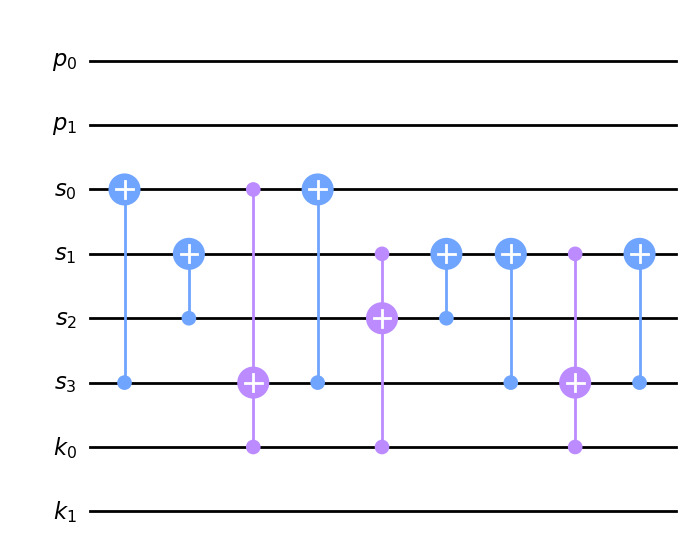

In [551]:
# Rotation operator for j = 0
S1 = QuantumCircuit(P_reg, S_reg, I_reg)

S1 = S1.compose(CSwap(control=I_reg[0], q0=S_reg[0], q1=S_reg[3]))
S1 = S1.compose(CSwap(control=I_reg[0], q0=S_reg[1], q1=S_reg[2]))
S1 = S1.compose(CSwap(control=I_reg[0], q0=S_reg[1], q1=S_reg[3]))

S1.draw('mpl')

In [552]:
# Inverse of S1 (apply the same swap operation backwards)
S1_inv = QuantumCircuit(P_reg, S_reg, I_reg)

S1_inv = S1_inv.compose(CSwap(control=I_reg[0], q0=S_reg[1], q1=S_reg[3]))
S1_inv = S1_inv.compose(CSwap(control=I_reg[0], q0=S_reg[1], q1=S_reg[2]))
S1_inv = S1_inv.compose(CSwap(control=I_reg[0], q0=S_reg[0], q1=S_reg[3]))

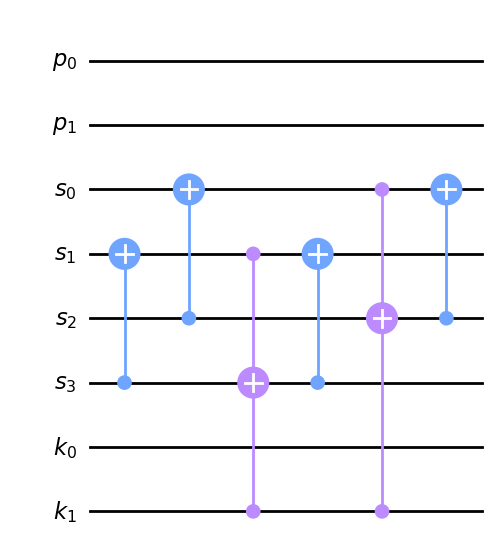

In [553]:
# Rotation operator for j = 1
S2 = QuantumCircuit(P_reg, S_reg, I_reg)

S2 = S2.compose(CSwap(control=I_reg[1], q0=S_reg[1], q1=S_reg[3]))
S2 = S2.compose(CSwap(control=I_reg[1], q0=S_reg[0], q1=S_reg[2]))

S2.draw('mpl')

In [554]:
# Inverse of S2 (apply the same swap operations backwards)
S2_inv = QuantumCircuit(P_reg, S_reg, I_reg)

S2_inv = S2_inv.compose(CSwap(control=I_reg[1], q0=S_reg[0], q1=S_reg[2]))
S2_inv = S2_inv.compose(CSwap(control=I_reg[1], q0=S_reg[1], q1=S_reg[3]))

In [555]:
# Convert above circuits to gates to make it easier to understand the
# circuit's scheme
S1_g = S1.to_gate(label='  $S_{1}$   ')
S2_g = S2.to_gate(label='  $S_{2}$   ')
S1_inv_g = S1_inv.to_gate(label=' $S_{1}^{-1}$ ')
S2_inv_g = S2_inv.to_gate(label=' $S_{2}^{-1}$ ')

# Building the circuit elements

In [556]:
# Initialize string, pattern and superposition of possible indexes
InitCirc = QuantumCircuit(P_reg, S_reg, I_reg, creg)

for i in range(0, P_len):
  if P & (1 << i):
    InitCirc.x(P_reg[i])

for i in range(S_len):
  if S & (1 << i):
    InitCirc.x(S_reg[i])

InitCirc.h(I_reg[:])

InitCirc.barrier()

In [557]:
# Rotate every string by its corresponding index value
RotatedCirc = QuantumCircuit(P_reg, S_reg, I_reg)

RotatedCirc = RotatedCirc.compose(S1_g)
RotatedCirc = RotatedCirc.compose(S2_g)

In [558]:
# Compare first bits of S with P
CompareCirc = QuantumCircuit(P_reg, S_reg, I_reg)

CompareCirc.cnot(S_reg[S_len-P_len+0], P_reg[0])
CompareCirc.cnot(S_reg[S_len-P_len+1], P_reg[1])

In [559]:
# Flip states for which previous comparison result equals 0
FlipGoodStateCirc = QuantumCircuit(P_reg, S_reg, I_reg)

FlipGoodStateCirc.x(P_reg[:])
FlipGoodStateCirc.cz(P_reg[0], P_reg[1])
FlipGoodStateCirc.x(P_reg[:])

In [560]:
# Revert operations
RevertCirc = QuantumCircuit(P_reg, S_reg, I_reg)

# Revert comparisons
RevertCirc.cnot(S_reg[S_len-P_len+0], P_reg[0])
RevertCirc.cnot(S_reg[S_len-P_len+1], P_reg[1])

# Revert string rotations
RevertCirc = RevertCirc.compose(S2_inv_g)
RevertCirc = RevertCirc.compose(S1_inv_g)

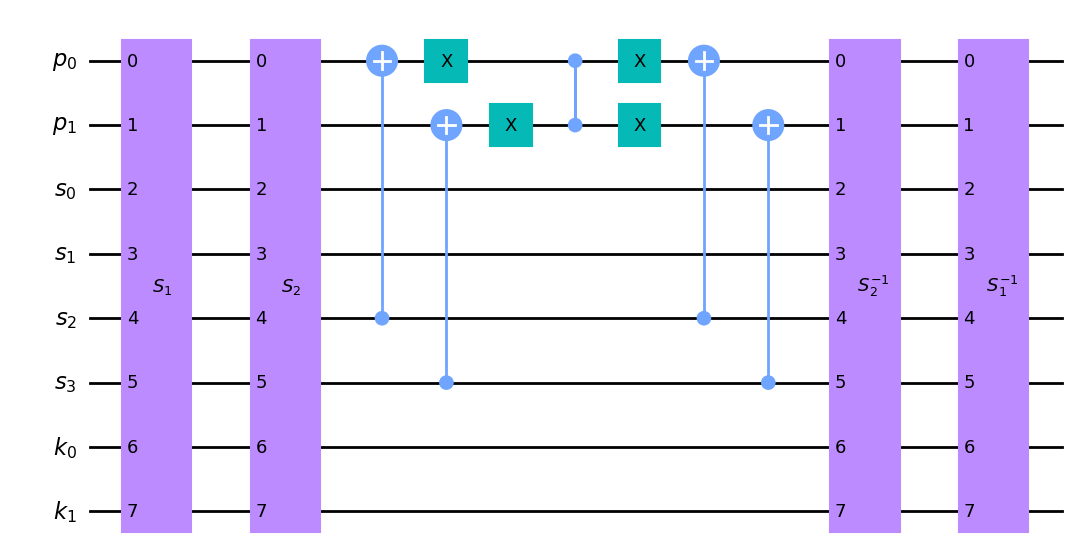

In [561]:
# Build the oracle with above components
Oracle = QuantumCircuit(P_reg, S_reg, I_reg)

Oracle = Oracle.compose(RotatedCirc)
Oracle = Oracle.compose(CompareCirc)
Oracle = Oracle.compose(FlipGoodStateCirc)
Oracle = Oracle.compose(RevertCirc)

Oracle.draw('mpl')

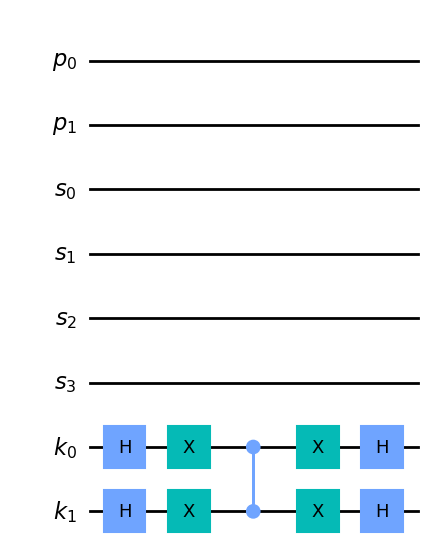

In [562]:
# Grover diffuser
Diffuser = QuantumCircuit(P_reg, S_reg, I_reg)

Diffuser.h([I_reg[0], I_reg[1]])
Diffuser.x([I_reg[0], I_reg[1]])
Diffuser.cz(I_reg[0], I_reg[1])
Diffuser.x([I_reg[0], I_reg[1]])
Diffuser.h([I_reg[0], I_reg[1]])

Diffuser.draw('mpl')

In [563]:
# Create oracle and diffuser gates
Oracle_g = Oracle.to_gate(label='   $U_{\omega}$   ')
Diffuser_g = Diffuser.to_gate(label='   $U_{s}$   ')

# Compose circuit with above elements

In [564]:
Grover = QuantumCircuit(P_reg, S_reg, I_reg, creg)

Grover = Grover.compose(InitCirc)

total_states = math.pow(2, I_len)
t = 2
good_states = 4 / math.pow(2, t)
iterations = math.floor((math.pi / 4) * math.sqrt(total_states / good_states))

for i in range(iterations):
  Grover = Grover.compose(Oracle_g)
  Grover = Grover.compose(Diffuser_g)
  Grover.barrier()

# Measure

In [565]:
for i in range(I_len):
  Grover.measure(I_reg[i], i)

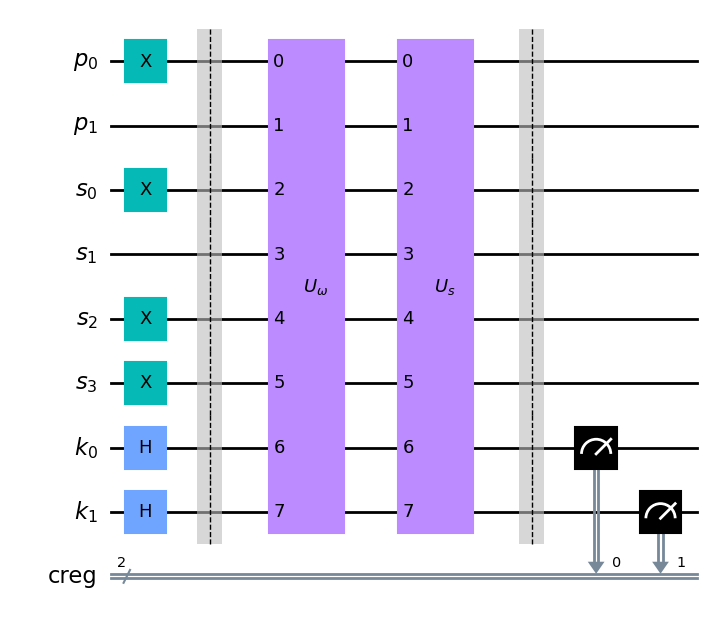

In [566]:
Grover.draw('mpl')

# Run simulation and plot results

# Ideal simulation

In [567]:
# Number of circuit executions
shots = 1024

In [568]:
# Run ideal simulation (without noise)
ideal_sim = AerSimulator()
Grover_compiled_ideal = transpile(Grover, ideal_sim)

job_ideal = execute(Grover_compiled_ideal, ideal_sim, shots=shots)

counts_ideal = job_ideal.result().get_counts(0)

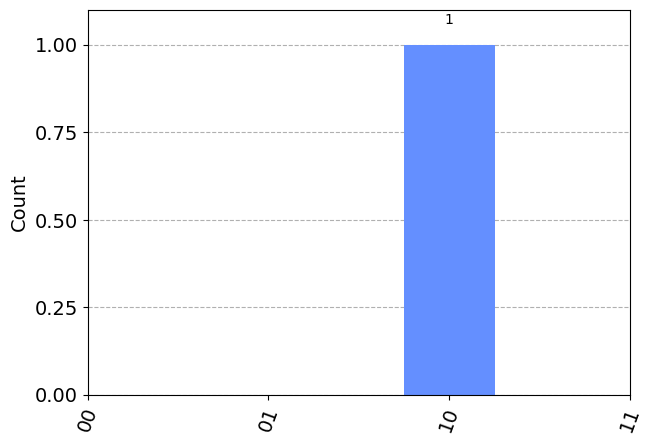

In [569]:
# Plot state probabilities
probs = {k: 0 for k in ['00', '01', '10', '11']}
for k, v in counts_ideal.items():
  probs[k] += v/shots
plot_histogram(probs)

# Adding noise model

Bit-flip noise model for measurement and qubit operators

In [570]:
# Probability of error on measure
p_measure = 0.01
# Probability of error on 1-qubit gate operator
p_gate1 = 0.0025

# QuantumError objects
error_meas = pauli_error([('X', p_measure), ('I', 1 - p_measure)])
error_gate1 = pauli_error([('X', p_gate1), ('I', 1 - p_gate1)])
error_gate2 = error_gate1.tensor(error_gate1)
# NOTE: Probability of error on 2-qubit gate operator is (p_gate1)^2

# Add errors to noise model
noise_bit_flip = NoiseModel()
noise_bit_flip.add_all_qubit_quantum_error(error_meas, "measure")
noise_bit_flip.add_all_qubit_quantum_error(error_gate1, ["u1", "u2", "u3"])
noise_bit_flip.add_all_qubit_quantum_error(error_gate2, ["cx"])

# NOTE: if every error probabilty is set to 0, then we get the same result
# as in the previous simulation

In [571]:
# Run noise simulation
noise_sim = AerSimulator(noise_model=noise_bit_flip)
Grover_compiled_noise = transpile(Grover, noise_sim)

job_noise = execute(Grover_compiled_noise, noise_sim, shots=shots)

counts_noise = job_noise.result().get_counts(0)

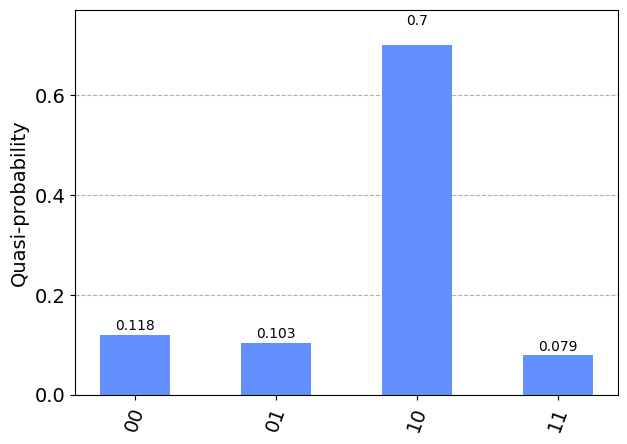

In [572]:
# Plot state probabilities
probs = {k: 0 for k in ['00', '01', '10', '11']}
for k, v in counts_noise.items():
  probs[k] += v/shots
plot_histogram(probs)